
<img src="https://www.unad.edu.co/images/footer/logo-unad-acreditacion-min.png" width="780" height="140" align="right"/>

<p align="center">Curso: Metodos Estadisticos</p>

<p align="center"> Código Curso: 203008067 </p>

<p align="center"> Grupo: 7 </p>

 <p align="center">  Tarea 3: Aprendizaje Estadistico No Supervisado </p>

 <p align="center">  Presentado por: Juan José García Sánchez </p>

<p align="center"> Código: 203008077</p>

 <p align="center"> Tutor(a): Mireya García García </p>

 <p align="center"> 26/11/2024 </p>

 <p align="center"> UNIVERSIDAD NACIONAL ABIERTA Y A DISTANCIA - UNAD </p>



# Objetivo General

### Aplicar modelos de agrupamiento sobre el dataset de precios dinamicos, usando conocimientos de estadistica y  aprendizaje automatico, para realizar un exploración de los datos  y encontrar posibles relaciones o patrones desconocidos entre caracteristicas. 

# Objetivos Especificos

### Examinar la relevancia de las caracteristicas, usando un analisis de componentes principales, para determinar cuales se va usaran en la exploración y clustering del dataset.

### Construir dos modelos de aprendizaje no supervisado, usando los algoritmos de agrupamiento KNN y aglomerativo jerarquico, para realizar un agrupamiento de los datos, y descubrir patrones o similarides entre los puntos de datos. 

### Evaluar los clusteres formados, usando los estadisticos de resumen, metricas y visualizaciones, para hallar su similaridad y relaciones encontradas. 

# Importar librerias

In [84]:
from itertools import chain
from enum import Enum

import pandas as pd
formato = "{:.3f}"
pd.options.display.float_format = formato.format

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, binarize, OneHotEncoder, OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn import metrics
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.decomposition import PCA

# Funciones para Metricas:

Se definen varias funciones de conveniencia para los calculos de las métricas de modelos, y para los calculos de las pruebas estadisticas.

In [2]:
def mostrar_parametros(variables, modelo, valores_t, valores_p, nombre_parametros="parametros"):
    """
    Contruir un dataframe para mostrar los resultados de un modelo de regresion.
    muestra los nombres de las variables, valores de parametros estimados,
    valores t y valores p.
    """
    summ = pd.DataFrame(
        {"variables":[*variables, "intercepto"], 
        "parametros":[*modelo.coef_.ravel(), *modelo.intercept_.ravel()],
        "valores t": valores_t,
        "valores_p": valores_p
        })

    return summ
        
def mostrar_metricas(y_real, y_predicho, decimales = 4, num_predictores=None):
    """
    Mostrar un tabla con resultados  de medidas de resumen de ajuste de
    modelos: calcula el MSE, RMSE, R2, MAE, R2_aj
    """ 
   # calculo del R cuadrado
    r2 = metrics.r2_score(y_real, y_predicho)
    
    summ = [ f"R2    : {r2:.{decimales}f}", ]

    # calculo R2 cuadrado ajustado, si se pasa un numero de predictores
    if num_predictores is not None:
        n = y_real.size
        
        r2_adj = 1 - ( (1 - r2) * (n - 1) ) / (n - num_predictores - 1) 

        summ.append(f"R2_adj: {r2_adj:.{decimales}f}")

    # Calculo de metricas MSE, RMSE, MAE
    
    mse = metrics.mean_squared_error(y_real, y_predicho)
    
    rmse = np.sqrt(mse)
 
    mae =  metrics.mean_absolute_error(y_real, y_predicho)
    
    summ.extend(
        (
        f"MSE   : {mse:.{decimales}f}",
        f"RMSE  : {rmse:.{decimales}f}",
        f"MAE   : {mae:.{decimales}f}",
        ))

    return "\n".join(summ)
    
    

def calcular_valor_t(X, y_real, y_pred, estadistico_estimado, estadistico_esperado):
    """
    Calcular valores t, comparando los valores estimados de un estadistico vs los valores
    esperados. se calculan los valores t y lo valores p correspondientes.
    """

    # obtener cantidad de puntos de datos
    n = y_real.shape[0]

    # calculo de resiudos, despues de haber entrenado un modelo 
    residuos = y_real - y_pred

    # Calculo de la desviacion estandar de los residuos. 
    # grado de libertad n-2 por ser un modelo regresion
    
    SC = residuos ** 2 

    std_residuos = np.sqrt(SC.sum()/(n - 2))

    # calculo de la desviacion estandar de las caracteriscas

    std_X = X.values.std()

    # calculo del error estandar. se invierte para usarlo directamente despues

    inv_std_error = (np.sqrt(n - 1)/std_residuos) * (std_X)

    # calculo del estadisticos t y p,  con t = (m_estimado - m_esperado)/error_estandar
    valor_t = (estadistico_estimado - estadistico_esperado) * inv_std_error

    valor_p = stats.t.sf(np.abs(valor_t), df= n - 2) * 2

    return valor_t, valor_p


# Funciones para Visualización:

Se definine varias funciones para graficar las predicciones de los modelos, y visualizar metricas

In [3]:
def grafico_linear_simple(x_entre, y_entre, x_prueba, y_prueba, modelo, titulo, titulo_x, titulo_y):
    plt.scatter(x_entre, y_entre, color="c", label="entrenamiento")
    
    plt.scatter(x_prueba, y_prueba, color="r", label="prueba")

    x_reg = np.linspace(np.min(x_entre), np.max(x_entre), 300).reshape(-1, 1)
    y_reg = modelo.predict(x_reg)
    
    plt.plot(x_reg, y_reg, "k--", label="linea regresión")

    plt.title(titulo)

    # Etiquetas de los ejes (opcional)
    plt.xlabel(titulo_x)
    plt.ylabel(titulo_y)
    plt.legend()

    # Mostrar el gráfico
    plt.show()


def grafico_real_vs_predicho(y_prueba, y_prueba_pred, titulo, titulo_x, titulo_y):
    linea = np.linspace(np.min(y_prueba_pred), np.max(y_prueba_pred), 300)
    
    plt.plot(linea, linea, color='k', linestyle='--', label='y = x')
    
    plt.scatter(y_prueba, y_prueba_pred, color="c")
    
    plt.title(titulo)
    
    # Etiquetas de los ejes (opcional)
    plt.xlabel(titulo_x)
    plt.ylabel(titulo_y)
    plt.legend()
    
    # Mostrar el gráfico
    plt.show()

def grafico_residuos(y_real, y_predicho, titulo, titulo_x, titulo_y, color="g"):
    """
    Calcular y graficar residuos de un modelo de regresion versus los valores
    predichos.
    """
    fig = plt.figure()

    ax = fig.add_subplot()

    residuos = y_real - y_predicho
    
    ax.scatter(y_predicho, residuos, color=color, alpha=0.6)

    ax.axhline(y=0, color="k", linestyle="--")

    ax.set_title(titulo)

    ax.set_xlabel(titulo_x)

    ax.set_ylabel(titulo_y)

    plt.show()
    

def matriz_confusion(y_real, y_predicho):
    matriz = metrics.confusion_matrix(y_real, y_predicho)
    
    heatmap(matriz, "Matriz Confusion", "d")
    
    ax = plt.gca()
    
    ax.set_xlabel("Valor Predicho")
    
    ax.set_ylabel("Valor Real")


def heatmap(matriz, titulo, formato=".2f", tamaño = (4, 4), mapa="Reds"):
    """
    Presentar un vision grafica de una matrix, com un mapa de calor.
    """
    plt.figure(figsize=tamaño)
    
    sns.heatmap(matriz, annot=True, cmap=mapa, fmt=formato)
    
    plt.title(titulo)


# Variables:

Las siguientes clases definen enumeraciones. Su función es simplemente contener constantes en un solo conjunto, para evitar los errores en el codigo.

In [4]:
# Variables categoricas del dataset
class Categ(Enum):
    locacion = "Location_Category"
    lealtad = "Customer_Loyalty_Status"
    tiempo_viaje = "Time_of_Booking"
    vehiculo = "Vehicle_Type"

# Variables numericas del dataset
class Num(Enum):
    viajes_pasados = "Number_of_Past_Rides"
    puntaje_promedio = "Average_Ratings"
    pasajeros = "Number_of_Riders" 	
    conductores = "Number_of_Drivers"
    duracion_esperada = "Expected_Ride_Duration"
    costo_historico = "Historical_Cost_of_Ride"

# Limpieza de datos

Se realiza el cargue de los datos, y se eliminan los datos nulos: 

In [5]:
# Carga los datos en un dataframe de Pandas

#limpiado de datos, el archivo csv debe estar en el mismo directorio
df_crudo = pd.read_csv('Anexo 1- Base de Datos dynamic_pricing.csv')

df_crudo.drop_duplicates()

df_modelos = df_crudo.dropna()

In [6]:
df_modelos

,Number_of_Riders,Number_of_Drivers,Location_Category,Customer_Loyalty_Status,Number_of_Past_Rides,Average_Ratings,Time_of_Booking,Vehicle_Type,Expected_Ride_Duration,Historical_Cost_of_Ride
0,90,45,Urban,Silver,13,4.470,Night,Premium,90,284.257
1,58,39,Suburban,Silver,72,4.060,Evening,Economy,43,173.875
2,42,31,Rural,Silver,0,3.990,Afternoon,Premium,76,329.795
3,89,28,Rural,Regular,67,4.310,Afternoon,Premium,134,470.201
4,78,22,Rural,Regular,74,3.770,Afternoon,Economy,149,579.681
...,...,...,...,...,...,...,...,...,...,...
995,33,23,Urban,Gold,24,4.210,Morning,Premium,11,91.390
996,84,29,Urban,Regular,92,4.550,Morning,Premium,94,424.156
997,44,6,Suburban,Gold,80,4.130,Night,Premium,40,157.365
998,53,27,Suburban,Regular,78,3.630,Night,Premium,58,279.095


In [13]:
ele = [ sujeto.value for sujeto in (*Num, *Categ)]

ele



['Number_of_Past_Rides',
 'Average_Ratings',
 'Number_of_Riders',
 'Number_of_Drivers',
 'Expected_Ride_Duration',
 'Historical_Cost_of_Ride',
 'Location_Category',
 'Customer_Loyalty_Status',
 'Time_of_Booking',
 'Vehicle_Type']

In [106]:
# escalamiento y codificacion de las varialbles, por medio del uso de una pipeline

# se usa la clase ColumnTransformer para juntar varias trasnformaciones juntas, y poder realizarlas en el las variables, como si fuera una sola unidad

orden_ordinales = [["Regular", "Silver", "Gold"], ["Economy", "Premium"]]

prep_categorico = ColumnTransformer([
    ('nominal', OneHotEncoder(), [Categ.locacion.value, Categ.tiempo_viaje.value]),
    ('ordinal', OrdinalEncoder(categories=orden_ordinales), [Categ.lealtad.value, Categ.vehiculo.value]),
                         ],
    remainder='passthrough')

prep = Pipeline([
    ("prep_categorico", prep_categorico),
    ("estandar", StandardScaler())
])


proceso_pca = Pipeline([
    ("preparacion", prep),
    ("PCA", PCA())
    ])

In [92]:
prep.fit(df_modelos)

estandarizado = prep.transform(df_modelos)


In [94]:
dfmodel_standar

,Location_Category_Rural,Location_Category_Suburban,Location_Category_Urban,Time_of_Booking_Afternoon,Time_of_Booking_Evening,Time_of_Booking_Morning,Time_of_Booking_Night,Customer_Loyalty_Status,Vehicle_Type,Number_of_Riders,Number_of_Drivers,Number_of_Past_Rides,Average_Ratings,Expected_Ride_Duration,Historical_Cost_of_Ride
0,-0.705,-0.689,1.375,-0.573,-0.548,-0.571,1.620,0.009,0.957,1.251,0.940,-1.264,0.489,-0.195,-0.472
1,-0.705,1.451,-0.727,-0.573,1.825,-0.571,-0.617,0.009,-1.045,-0.100,0.626,0.750,-0.453,-1.152,-1.062
2,1.418,-0.689,-0.727,1.746,-0.548,-0.571,-0.617,0.009,0.957,-0.776,0.206,-1.708,-0.614,-0.480,-0.228
3,1.418,-0.689,-0.727,1.746,-0.548,-0.571,-0.617,-1.248,0.957,1.208,0.048,0.579,0.121,0.700,0.522
4,1.418,-0.689,-0.727,1.746,-0.548,-0.571,-0.617,-1.248,-1.045,0.744,-0.266,0.818,-1.119,1.006,1.108
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,-0.705,-0.689,1.375,-0.573,-0.548,1.751,-0.617,1.266,0.957,-1.155,-0.214,-0.888,-0.108,-1.803,-1.503
996,-0.705,-0.689,1.375,-0.573,-0.548,1.751,-0.617,-1.248,0.957,0.997,0.101,1.432,0.672,-0.114,0.276
997,-0.705,1.451,-0.727,-0.573,-0.548,-0.571,1.620,1.266,0.957,-0.691,-1.106,1.023,-0.292,-1.213,-1.150
998,-0.705,1.451,-0.727,-0.573,-0.548,-0.571,1.620,-1.248,0.957,-0.311,-0.004,0.955,-1.440,-0.846,-0.499


# Analisis de componentes principales (PAC)

El analisis de componentes principales, permite crear una serie de nuevas variables para el analisis de datos.

### Ajuste del modelo:

In [108]:
#Ajustando los datos
proceso_pca.fit(df_modelos)

# inspeccionar modelo PCA
modelo_pca= proceso_pca.named_steps["PCA"]

# extraer los nombres de la caracteristicas. como se aplicaron trasnformaciones, las categoricas cambiaron de nombre, y las numericas se pasaron al final, es necesario extraerlas
#para conocer exactamente el nombre y el orden
caract_trans = tuple(
    chain.from_iterable(
        trans.get_feature_names_out() for trans in prep.named_steps["prep_categorico"].named_transformers_.values()
    ))


In [112]:
componentes = pd.DataFrame(modelo_pca.components_, columns=caract_trans)

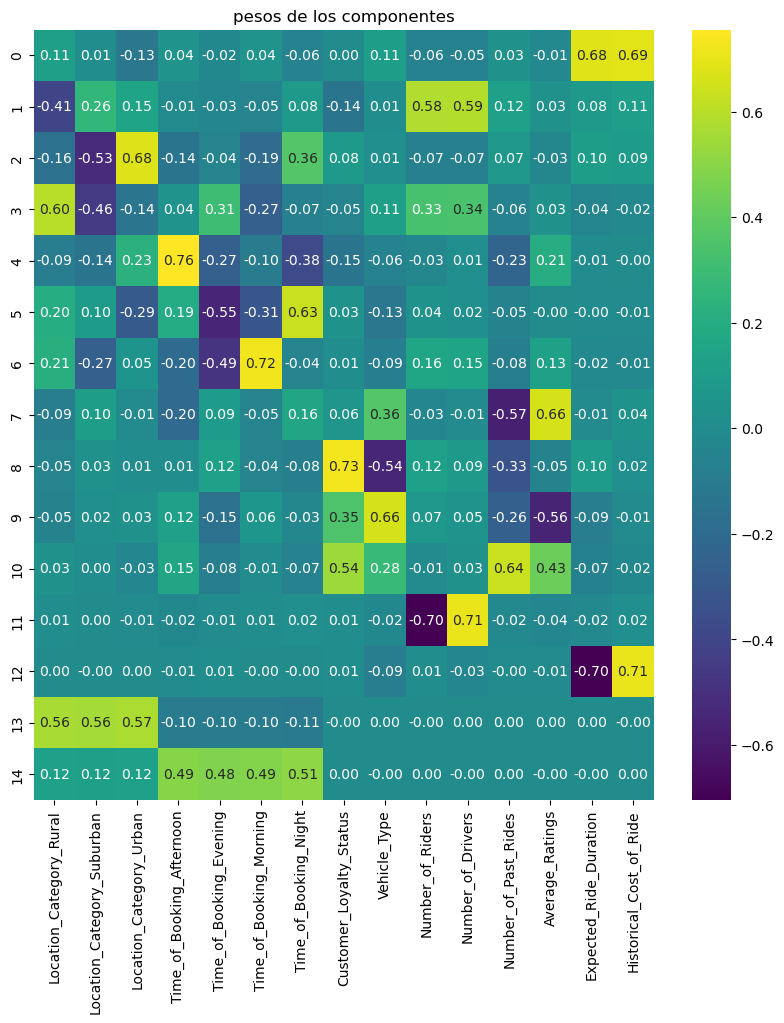

In [115]:
heatmap(componentes, "pesos de los componentes",  tamaño=(10,10), mapa="viridis")

<Axes: >

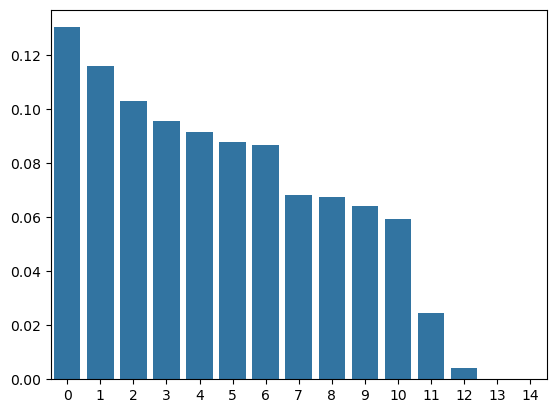

In [116]:
sns.barplot(modelo_pca.explained_variance_ratio_)

In [117]:
100/14

7.142857142857143

### Visualización:

### Metricas y Parametros:

In [14]:
print("metricas entrenamiento:")
print(mostrar_metricas(y_entre_lin, y_entre_pred, num_predictores=1))

print("metricas prueba:")
print(mostrar_metricas(y_prueba_lin, y_prueba_pred, num_predictores=1))

metricas entrenamiento:
R2    : 0.0024
R2_adj: 0.0009
MSE   : 35665.2333
RMSE  : 188.8524
MAE   : 158.8371
metricas prueba:
R2    : -0.0067
R2_adj: -0.0100
MSE   : 33338.8161
RMSE  : 182.5892
MAE   : 151.8171


In [116]:
# pendientes e intercepto, concatenados para el calculo del test t
parametros = np.append(modlin_viajes.coef_, modlin_viajes.intercept_)

valores_t, valores_p = calcular_valor_t(viajes_prueba, y_prueba_lin, y_prueba_pred, parametros, 0)

mostrar_parametros([Num.viajes_pasados.value], modlin_viajes, valores_t, valores_p)

,variables,parametros,valores t,valores_p
0,Number_of_Past_Rides,0.317,0.895,0.372
1,intercepto,353.132,996.131,0.000


### Analisis:

La pendiente hallada de $0.317$ refleja en el modelo que el costo del viaje aumenta en 0.317 unidades monetarias por cada viaje pasado adicional. El intercepto mostraría un precio base para el costo de 353 unidades monetarias.

los valores de $R^2$ de $-0.67\%$, y $R^1_{adj}$  de $-1\%$, son negativos y bajos calculados en los datos de prueba. El RMSE ($182.58$) muestra un valor muy alto, indicando que la diferencia entre valores predichos y reales es muy alta. Todas estas metricas indican que el modelo es pesimo para predecir el costo. 

La prueba estadistica aplicada en los parametros muestra que la pendiente tiene un valor $P$ de 0.372, mucho mayor al limite de $0.05$. Por lo tanto, se acepta la hipotesis nula, indicando que no hay correlación entre el costo y el número de viajes pasados. el intercepto tiene un valor $P$ menor al limite, pero no tiene sentido tomarlo en cuenta si la pendiente no tiene significancial.


# KNN (Agrupamiento K-Medias)

La regresión lineal multiple es una generalización de la simple: se realiza ajustando una ecuación lineal de multiples variables a los datos en estudio, de acuerdo a la siguiente ecuación:

$$ y = \beta_1 \cdot X + b_0$$

$X$ es un vector conteniendo las variables independientes, $\beta_1$ es el vector conteniendo las pendientes para cada variable, y  $b_0$ es el intercepto con el eje y. Los parametros se ajustan de forma semejante al caso simple, por medio de un ajuste de miniumos cuadrados. La interfaz `LinearRegression` Tambien puede usarse para realizar regresiones lineales multiples, siempre y cuando todas las variables sean numericas. En este caso, tambien se hace una division de los datos en proporciones $30 \% - 70 \%$; y se usan las siguientes caracteristicas como variables independientes: 

- Cantidad de pasajeros en el área.
- Cantidad de conductores en el área.
- Cantidad de viajes pasado.
- Duración esperada del viaje.

In [117]:
# K-Means con 4 clusters
modelo_kmeans = KMeans(n_clusters=3, init='random', n_init=10, max_iter=300, tol=1e-04, random_state=60)

modelo_kmeans.fit(X_clustering)


KMeans(init='random', n_clusters=3, n_init=10, random_state=60)

In [33]:
# Obtener los centros de los clústeres y las etiquetas de clúster para cada punto de datos
centroids = modelo_kmeans.cluster_centers_
labels = modelo_kmeans.labels_

print(centroids)
print(labels)

[[8.72588010e-01 2.95539482e-01 4.79882030e-02 2.62492948e-01
  3.42215989e-01 1.43369176e-04 5.37634409e-03 2.06989247e-01
  4.25627240e-01 5.52999951e-01 5.57526882e+00 2.40161290e+01
  3.76344086e-01 2.70430108e+00 3.00000000e+00]
 [8.92742641e-01 3.05236691e-01 4.12032345e-02 2.50206856e-01
  2.87264878e-01 5.39007092e-04 1.74940898e-02 1.65957447e-01
  4.22931442e-01 5.44382888e-01 5.49361702e+00 1.30893617e+01
  6.46808511e-01 2.71914894e+00 1.45106383e+00]
 [9.14611872e-01 2.89453889e-01 6.21110230e-02 2.43998628e-01
  3.39184112e-01 1.02222222e-02 1.74485597e-02 4.62962963e-02
  4.12992357e-01 5.87011832e-01 5.50740741e+00 3.86666667e+00
  1.02592593e+00 2.27777778e+00 2.18518519e-01]]
[2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1

In [118]:
df_centroides = pd.DataFrame(modelo_kmeans.cluster_centers_)

df_centroides.columns = caracteristicas

### Ajuste del modelo:

In [35]:
y_entre_pred = modmul.predict(X_entre_lin[caracteristicas])
y_prueba_pred = modmul.predict(X_prueba_lin[caracteristicas])

### Visualización:

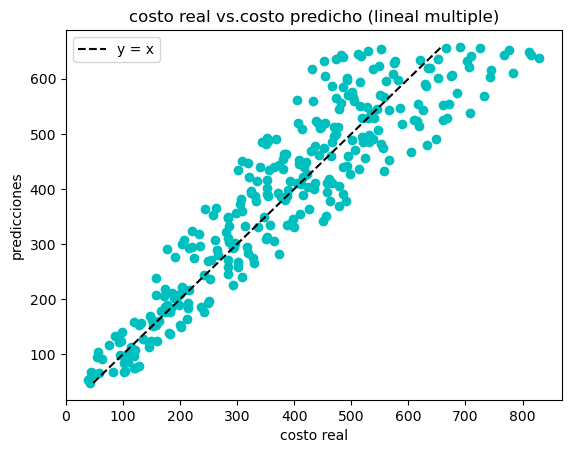

In [36]:
grafico_real_vs_predicho(y_prueba_lin, y_prueba_pred,
                         'costo real vs.costo predicho (lineal multiple)',
                         'costo real',
                         'predicciones')

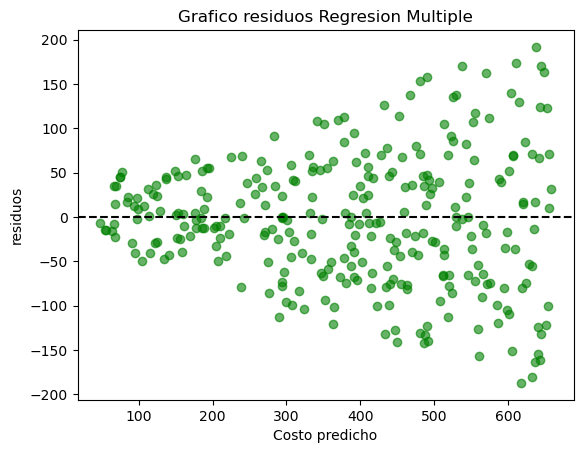

In [37]:
grafico_residuos(y_prueba_lin, y_prueba_pred, 
                 "Grafico residuos Regresion Multiple", 
                 "Costo predicho", 
                 "residuos")

### Analisis:

El gráfico de predicciones vs. valores reales sigue la tendencia de la recta $y = x$. Muestra que el modelo lineal multiple es capaz de predecir los valores del costo. La dispersión de los puntos es similar al modelo linea de *Costo vs. duración esperada*. Como tambien se esta incluyendo la variable de *duración esperada del viaje* en el modelo, tiene sentido que las graficas de regresión se parezcan.

El gráfico de residuos muestra que hay una tendencia de los errores, similar a la que se presento en el modelo *Coso vs. duración esperada*. Esto muestra que la tendencia de los errores se deebe unicamente a la inclusión de la variable de *duración esperada del viaje*. Tampoco se cumple el criterio de homocestadicidad, lo que limita el analisis de las pruebas estadisitcas aplicadas. 

### Metricas y Parametros:

In [39]:
print("metricas entrenamiento:")
print(mostrar_metricas(y_entre_lin, y_entre_pred, num_predictores=4))

print("metricas prueba:")
print(mostrar_metricas(y_prueba_lin, y_prueba_pred, num_predictores=4))

metricas entrenamiento:
R2    : 0.8697
R2_adj: 0.8689
MSE   : 4659.3354
RMSE  : 68.2593
MAE   : 53.8421
metricas prueba:
R2    : 0.8416
R2_adj: 0.8395
MSE   : 5244.8792
RMSE  : 72.4215
MAE   : 57.3789


In [19]:
# pendientes e intercepto, concatenados para el calculo del test t
parametros = np.append(modmul.coef_, modmul.intercept_)

valores_t, valores_p = calcular_valor_t(X_prueba_lin[caracteristicas], y_prueba_lin, y_prueba_pred, parametros, 0)

mostrar_parametros(caracteristicas, modmul, valores_t, valores_p)

,variables,parametros,valores t,valores_p
0,Number_of_Riders,0.006,0.065,0.949
1,Number_of_Drivers,0.404,4.033,0.000
2,Number_of_Past_Rides,0.003,0.032,0.975
3,Expected_Ride_Duration,3.559,35.575,0.000
4,intercepto,7.862,78.587,0.000


### Analisis:

La coeficientes hallados son las pendientes, que se pueden interpretar cada una como:

- EL costo aumenta 0.006 unidades cuando el número de pasajeros disponibles en el área aumenta.
- El costo aumenta 0.404 unidades por cada conductor que haya disponible en el área.
- El costo aumenta 0.003 unidades por cada viaje que el vehiculo hay completado.
- El costo aumenta 3.559 unidades por cada minuto adicional que aumente la duración esperada.
- El intercepto muestra un costo base de 7.862.

La pendiente hallada para la duración esperada es muy cercana a la hallada en el modelo lineal simple.

En los datos de preuba, Las metricas de $R^2$ y $R^2_{adj}$ tienen el valor de $84.16\%$ y de $83.95\%$, estando muy cercanos entre ellos. El RMSE de ($72.42$) es un valor mucho menor comparado con la magnitud del costo, mostrando una baja desviación entre predicciones y valores reales. Este modelo predice bien el costo, y es ligeramente mejor que el lineal simple de *Costo vs. Duración esperada*.

La prueba estadistica revela que *El número de condutores disponibles* y *la duración esperada del viaje* son las unicas variables significativas del modelo, ya que estan bajo el umbral de $0.05$. Sin embargo, debido a los resultados vistos en la grafica de residuos, se pierde generalidad en la prueba estadistica, y tambien es necesario tomar acciones para reestablecer la homocesdasticidad.


# Agrupamiento Jerarquico

### Ajuste del modelo:

In [115]:
df_clustering = df_entre.drop(["año", "department", "dia", "mes", "nombre_dia", "quarter"], axis=1)
X_clustering = df_clustering.values
caracteristicas = df_clustering.columns

In [131]:
modelo_agg = AgglomerativeClustering(n_clusters=3)

labels = modelo_agg.fit_predict(X_clustering)

In [133]:
# Obtener los centros de los clústeres y las etiquetas de clúster para cada punto de datos
labels = modelo_agg.labels_

print(labels)

[2 1 1 2 2 0 0 0 1 1 0 0 0 0 2 1 1 0 2 2 1 0 0 1 2 1 2 2 0 0 0 1 1 0 1 0 1
 2 2 0 1 2 1 0 0 1 0 0 0 1 0 0 0 1 2 2 2 1 1 0 0 1 2 0 0 2 0 1 2 1 0 1 1 0
 0 2 2 0 0 1 2 1 1 0 1 2 2 0 0 1 2 0 1 0 1 0 1 0 2 2 2 1 0 1 0 1 0 0 0 1 2
 2 0 2 1 0 1 0 1 0 0 1 2 2 2 1 0 0 1 0 0 1 2 1 2 1 2 0 0 0 1 1 0 0 2 2 1 2
 1 0 0 0 1 1 0 2 1 2 2 0 1 0 0 1 0 1 0 2 2 2 1 0 1 1 0 1 0 0 0 2 2 1 0 0 0
 1 1 0 2 0 1 2 2 1 0 1 0 0 1 0 1 2 0 2 2 0 1 0 0 1 0 1 1 2 0 0 2 1 0 0 0 1
 1 2 2 1 0 0 0 1 2 0 1 1 0 2 1 2 0 0 0 0 2 1 2 1 0 1 1 2 0 2 0 0 0 1 0 1 1
 2 1 0 0 1 0 0 1 1 2 2 0 1 0 0 1 0 0 0 1 1 1 2 2 2 0 0 0 1 0 1 0 1 1 2 2 0
 0 1 0 1 0 1 0 1 2 2 2 0 0 0 1 0 1 1 1 2 2 2 0 0 0 1 1 0 1 1 2 0 2 2 0 1 0
 0 0 1 1 1 2 2 2 0 0 0 1 0 1 1 2 2 1 2 0 0 0 0 1 0 1 1 1 2 0 2 0 2 0 0 0 1
 1 1 2 1 2 0 0 2 0 1 0 0 1 1 2 1 0 0 2 2 1 0 0 1 0 1 0 1 0 2 2 2 1 0 0 0 1
 1 2 1 0 0 2 2 0 0 1 2 1 1 0 2 0 2 0 1 0 0 1 0 2 0 2 1 1 2 1 0 0 1 0 0 0 2
 2 1 2 0 0 1 0 2 2 2 1 0 0 0 1 0 0 0 1 2 0 2 2 1 1 1 0 1 2 0 2 1 0 0 1 2 0
 1 1 0 0 1 0 2 2 0 1 0 1 

In [135]:
print(f"Tamaños de los cluster con el método agglomerative clustering: {np.bincount(labels)}")

Tamaños de los cluster con el método agglomerative clustering: [288 233 170]


Text(0, 0.5, 'Distancia entre clusters')

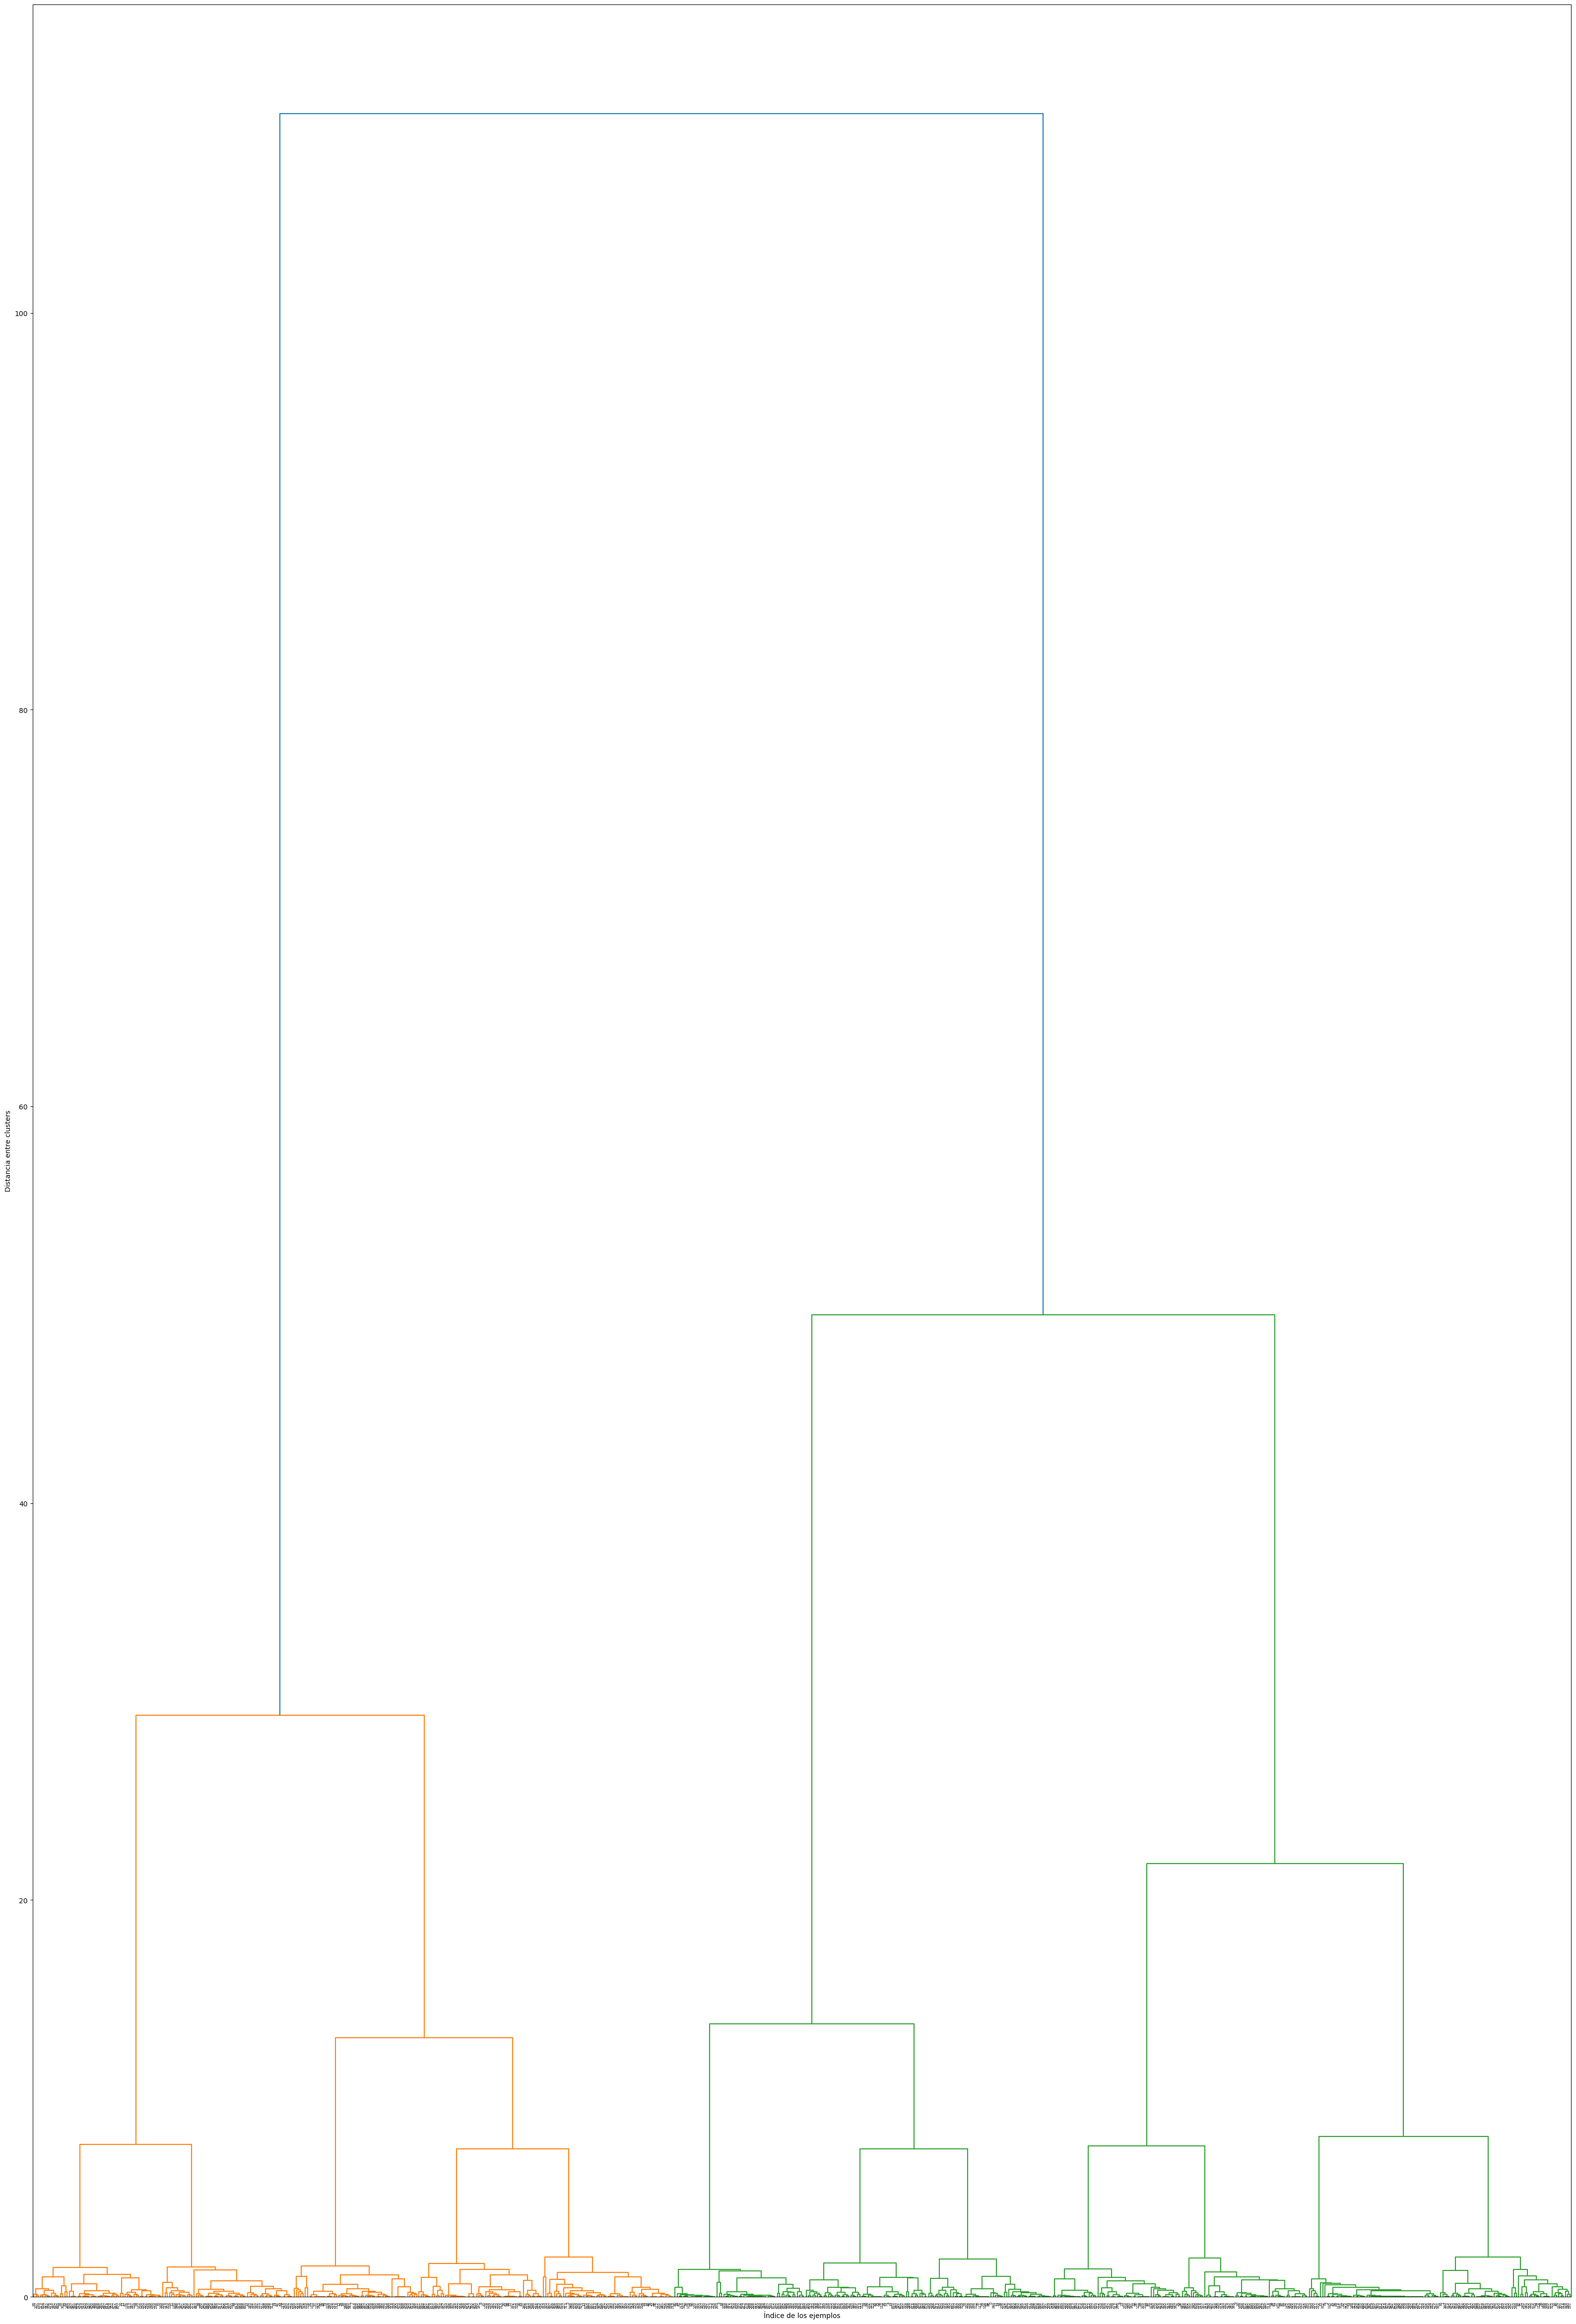

In [130]:
from scipy.cluster.hierarchy import dendrogram, ward

# Aplicamos ward clustering a los datos X2
# La función ward de SciPy devuelve una matriz con las distancias al realizar el agrupamiento
linkage_array = ward(X_clustering)


# Dendrograma para linkage_array que contiene las distancias entre clusters
plt.figure(figsize=(40, 60))
dendrogram(linkage_array)
plt.xlabel("Índice de los ejemplos")
plt.ylabel("Distancia entre clusters")

In [49]:
# caracteristicas que se mencionaron en el apartado anterior
caract_log = [Categ.locacion.value, Categ.tiempo_viaje.value, Categ.lealtad.value, Categ.vehiculo.value]

# se usa la clase ColumnTransformer para juntar varias trasnformaciones juntas, y poder realizarlas en el las variables, como si fuera una sola unidad

prep_categorico = ColumnTransformer([
    ('codificado_nominal', OneHotEncoder(), [Categ.locacion.value, Categ.tiempo_viaje.value]),
    ('codificado_ordinal', OrdinalEncoder(), [Categ.lealtad.value, Categ.vehiculo.value]),
                         ],
    remainder='passthrough')

modlog = Pipeline([
    ("prep_categorico", prep),
    ("standar", StandardScaler())
])


# La clase binarize permite dividir los datos en grupos de  1 y 0, dependiendo de cual sea el limite de la division. En este caso es cuatro
puntaje_limite = 4

calidad = binarize(df_modelos[[Num.puntaje_promedio.value]], threshold=puntaje_limite).ravel()

X_entre_log, X_prueba_log, calidad_entre, calidad_prueba = train_test_split(df_modelos[caract_log],
                                                        calidad, 
                                                        train_size=0.7,
                                                       random_state=600) 

In [50]:
#construyendo las variables para el nivel de produtividad (productividad alta: 1; productividad baja: 0)

modlog = Pipeline([
    ("preprocesamiento", prep),
    ("logistico", LogisticRegression())
])

modlog.fit(X_entre_log, calidad_entre)

Pipeline(steps=[('preprocesamiento',
                 ColumnTransformer(transformers=[('codificado_nominal',
                                                  OneHotEncoder(),
                                                  ['Location_Category',
                                                   'Time_of_Booking']),
                                                 ('codificado_ordinal',
                                                  OrdinalEncoder(),
                                                  ['Customer_Loyalty_Status',
                                                   'Vehicle_Type'])])),
                ('logistico', LogisticRegression())])

In [51]:
calidad_entre_pred = modlog.predict(X_entre_log)
calidad_prueba_pred = modlog.predict(X_prueba_log)

El uso de los encoders para las variables categoricas ofusca cuales variables se estan usando realmente para el modelo. El siguiente fragmento es para extraer las caracteristicas usadas por el modelo, y poder presentarlas mas claramente

In [52]:
### fragmento de codigo para visualizar mejor a que variable corresponde cada parametro hallado
desglose_caract = []

encoder = modlog.named_steps["preprocesamiento"].transformers_[0][1]

for categ in encoder.categories_:
    desglose_caract.extend(categ)

desglose_caract.extend(caract_log[-2:])

### Radios Odd

In [53]:
parametros_log = np.append(modlog.named_steps["logistico"].coef_, modlog.named_steps["logistico"].intercept_)

radios_odd = pd.DataFrame({"variable": desglose_caract + ["intercepto"], 
                           "radios odd":np.exp(parametros_log)})

display(radios_odd)

,variable,radios odd
0,Rural,0.918
1,Suburban,1.025
2,Urban,1.053
3,Afternoon,1.168
4,Evening,0.721
5,Morning,1.270
6,Night,0.927
7,Customer_Loyalty_Status,0.959
8,Vehicle_Type,0.937
9,intercepto,2.362


### Analisis 

Los odd radios son la cantidad adimensional $\frac{P}{1-P}$ de la ecuación del modelo logistico. La expresion nos indica una relación sobre las probabilidades de la ocurrencia del evento, sobre la no ocurrencia. En este caso, el evento es que la calidad de viaje sea buena, y la ausencia del evento implica que la calidad del viaje sea mala. El odd radio se puede desglosar para cada uno de los parametros del modelo, y se interpretan de forma similar. Para el modelo presente seria:

- Para la variable locación del viaje:

> - Nivel Rural: indica que, en zona rural, es $0.918$ veces más probable que el servicio sea bueno, frente a que el servicio sea malo. Esto en realidad que implica que es $1/0.918 = 1.09$  veces mas probable que el servicio sea malo en zona rural.
> - Nivel Suburbano: indica que, en zona suburbana, es $1.025$ veces mas probable que el viaje sea bueno, respecto a que el viaje sea malo.
> - Nivel Urbano, En la zona urbana, es $1.053$ veces más probable que el servicio sea bueno, frente a que sea malo.

- Para la variable Hora del viaje:

> - Nivel tarde: En las horas de la tarde, es $1.168$ veces más probable que el servicio sea bueno, respecto a que sea malo.
> - Nivel anochecer: Pasa el mismo caso que en la variable locación. En realidad, al anochecher es $1/0.721 = 1.387$ veces más probable que el viaje sea malo, frente a que sea bueno.
> - Nivel Mañana: Es $1.27$ veces más probable que el viaje sea bueno, respecto a que sea malo, en las horas de la mañana.
> - Nivel Noche: En las horas de la noche, es $1/0.927 = 1.079$ veces mas probable que el servicio sea malo, frente a que el servicio sea bueno.

- Para la variable lealtad del cliente: la probabilidad de que el servicio sea malo es $1/0.959 = 1.043$ veces más probable respecto a que el servicio sea bueno. Como la variable es ordinal (0=clase oro, 1=clase plata, 2=clase regular), por cada nivel que aumente la lealtad, la probabilidad de que sea malo aumenta tambien.

Para la variable tipo de vehiculo: la probabilidad de que el servicio sea malo es $1/0.937 = 1.067$ veces más que la probabilidad sea bueno. Como la variable ses ordinal (0=premium, 1= economy), por cada nivel que aumente la variable, la probabilidad de que sea malo aumenta tambien.

### Metricas y Parametros:

In [54]:
acc_entre = metrics.accuracy_score(calidad_entre, calidad_entre_pred)
acc_prueba = metrics.accuracy_score(calidad_prueba, calidad_prueba_pred)

print(f"exactitud entrenamiento: {acc_entre:0.3f}", )
print(f"exactitud prueba: {acc_prueba:0.3f}")

exactitud entrenamiento: 0.683
exactitud prueba: 0.680


In [152]:
print(metrics.classification_report(calidad_prueba, calidad_prueba_pred))

              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00        96
         1.0       0.68      1.00      0.81       204

    accuracy                           0.68       300
   macro avg       0.34      0.50      0.40       300
weighted avg       0.46      0.68      0.55       300



C:\Users\frajg\miniconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\frajg\miniconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\frajg\miniconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


### Visualización:

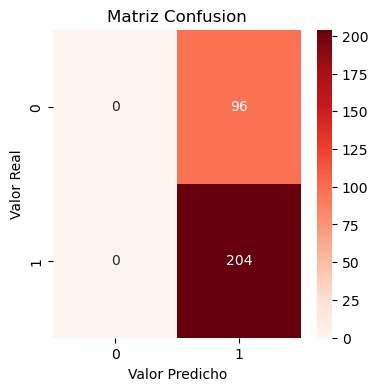

In [201]:
matriz_confusion(calidad_prueba, calidad_prueba_pred)

In [55]:
# pesos y sesgo, concatenados para el calculo del test t
caract_trans = pd.DataFrame(modlog.named_steps["preprocesamiento"].transform(X_prueba_log), columns=desglose_caract  )

valores_t, valores_p = calcular_valor_t(caract_trans, calidad_prueba, calidad_prueba_pred, parametros_log, 0)

mostrar_parametros(columnas, modlog.named_steps["logistico"], valores_t, valores_p)

,variables,parametros,valores t,valores_p
0,Rural,-0.085,-1.468,0.143
1,Suburban,0.024,0.421,0.674
2,Urban,0.052,0.896,0.371
3,Afternoon,0.155,2.664,0.008
4,Evening,-0.327,-5.623,0.000
5,Morning,0.239,4.116,0.000
6,Night,-0.076,-1.309,0.192
7,Customer_Loyalty_Status,-0.042,-0.728,0.467
8,Vehicle_Type,-0.065,-1.123,0.262
9,intercepto,0.860,14.784,0.000


### Analisis:

Las metricas de exactitud del modelo logistico muestran que fue capaz de predecir el $68\%$ de los datos de prueba, teniendo un precision alta. Sin embargo, observando las metricas de clasificación y la matrix de confusión del modelo, se puede observar que esa precision solo aplica a los valores de calidad buenos. El modelo es incapaz de predecir si se va a dar un servicio de calidad baja. Esto tambien ser refleja por los valores de recall y el  f1-score de cero para la variable baja: estas metricas no se calculan por que no hay predicciones para una calidad baja.

Las pruebas estadisticas sobre los parametros indican que las unicas variables que tienen significancia son las siguientes: 

- La variable de la hora dle viaje, en los niveles de la tarde, el anochecer y la mañana 

- la constante independiente que se agrega al modelo logistico.

Estos resultados, sin embargo, se ven limitados por la nula capacidad del modelo de poder predecir los casos de calidad baja.

## Conclusiones

### Regresion Lineal Simple

- El modelo de *Costo vs. viajes pasados* fue el que peor se desempeño entre todos los modelos, con un ajuste de $-0.68\%$. El modelo de *Costo vs. duración esperada* fue mejor que el anterior, teniendo un ajuste del $84\%$.

- Los resultados de la prueba estadistica del t-student permiten concluir que la variable de viajes pasados no tiene significancia en la predicción del costo. La prueba estadistica mostraria que la duración esperada si tiene significancia, pero esta conclusión se ve limitada por la falta de la homocedasticidad en el grafico de residuos. Se debe realizar una trasnformación de los datos para poder establecer que la varianza de los errores sea constante. Una de tales trasnformaciones para las regresiones lineales es la función logaritmica. Tambien es posible realizar una regresión lineal con pesos ponderados para evitar la varianza no constante.

### Regresion Lineal Multiple

- El modelo de regresión lineal multiple es el mejor de los construidos, teniendo un ajuste de $84.16\%$. El grafico valores predichos vs. valores reales mostraron igualmente que se dio un buen ajuste, y las demas metricas mostraron buenos resultados.

- El resultado de la prueba estadistica mostraria que las variables con significancia serian el número de conductores en el área, y la duración esperada del viaje. Sin embargo, pasa lo mismo que en el modelo anterior, donde la homocedasticidad no se observa en el grafico de residuos. En el caso del modelo linear multiple, tambien se pueden aplicar transformaciones a las variables para tener varianza constante, o el uso de una regresión lineal ponderada.

### Regresion Logistica

- El modelo logistico tuvo un ajuste menor al modelo lineal multiple, y superior al primer modelo lineal. tuvo una precisión del $68\%$, pero solo es capaz de predecir valores altos de la calidad. Esto se debe a que los datos en estan sesgados hacia valores altos de la calidad, por lo que se debe hacer un balanceo de los datos para mejorar el modelo

- Se encontró que solo los niveles de la variable de la hora de viaje son significativos en la predicción de la calidad. Sin embargo, estos resultados se ven limitados por la prescencia del desbalanceo de los datos.

## Enlaces Sustentación:

## [Diapositivas](https://view.genially.com/67206a039d6a5ac3863f8b56/presentation-informe-aprendizaje-estadistico)

## [Presentación](https://youtu.be/KnqF6oqtnYY)

# Referencias

- Kane, F. (2017). Hands-On Data Science and Python Machine Learning. Packt
Publishing.

- Rubio, M. (2019). Estadística con aplicaciones en R. Utadeo.

- Samuels, M., Witmer, J., & Shaffner, A. (2012). Fundamentos de Estadística Para Las Ciencias de la Vida (4th ed.). Pearson.

